In [1]:
import os
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
class generator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class = 10):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc1_bn = nn.BatchNorm1d(128*4)
        self.fc2 = nn.Linear(self.fc1.out_features, 128)
        self.fc3 = nn.Linear(self.fc2.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1_bn(self.fc1(input)), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.tanh(self.fc3(x))

        return x

In [3]:
class discriminator(nn.Module):
    # initializers
    def __init__(self, input_size=32, n_class=10):
        super(discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(self.fc1.out_features, 512)
        self.fc3 = nn.Linear(self.fc2.out_features, n_class)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.fc1(input), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.sigmoid(self.fc3(x))

        return x

In [4]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
    
    G.eval()
    
    test_images = G(noise)
        
    G.train()
    size_figure_grid = 5
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
    
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(5*5):
        i = k // 5
        j = k % 5
        ax[i, j].cla()
        ax[i, j].imshow(test_images[k, :].cpu().data.view(28, 28).numpy(), cmap='gray')

    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [5]:
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()

In [6]:
batch_size = 128
lr = 0.0002
train_epoch = 8

# data_loader
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

In [7]:
# network_initialize
G = generator(input_size=100, n_class=28*28)
D = discriminator(input_size=28*28, n_class=1)
G.cpu()
D.cpu()

discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
Gen_optimizer = optim.Adam(G.parameters(), lr=lr)
Disc_optimizer = optim.Adam(D.parameters(), lr=lr)

In [11]:
# results save folder
if not os.path.isdir('MNIST_GANBN_results'):
    os.mkdir('MNIST_GANBN_results')
if not os.path.isdir('MNIST_GANBN_results/Samples'):
    os.mkdir('MNIST_GANBN_results/Samples')

[1/8]: loss_d: 0.077, loss_g: 8.218


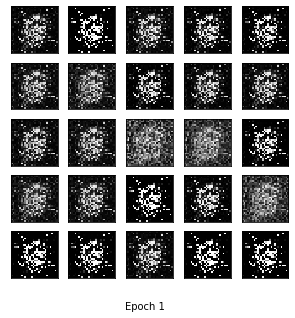

[2/8]: loss_d: 0.129, loss_g: 7.756


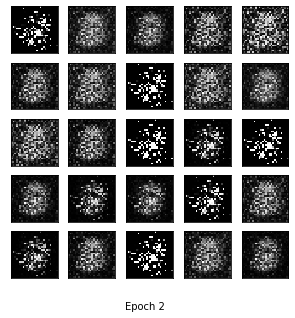

[3/8]: loss_d: 0.173, loss_g: 7.313


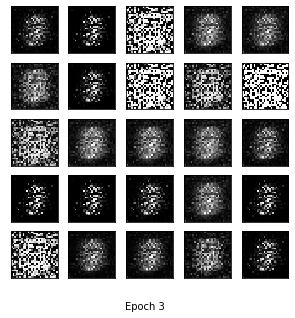

[4/8]: loss_d: 0.362, loss_g: 5.715


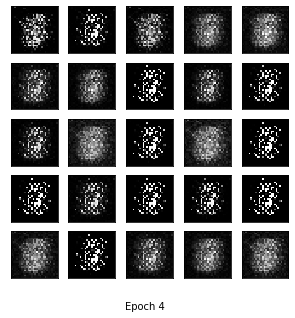

[5/8]: loss_d: 0.487, loss_g: 4.064


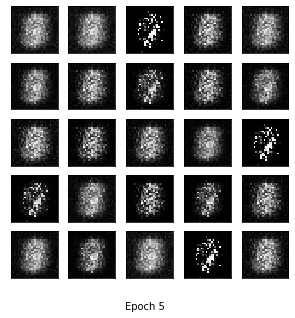

[6/8]: loss_d: 0.733, loss_g: 2.584


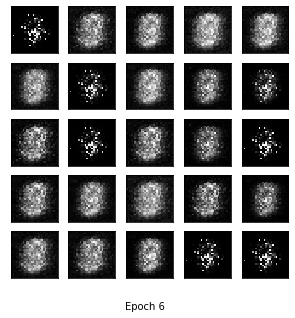

[7/8]: loss_d: 0.820, loss_g: 1.982


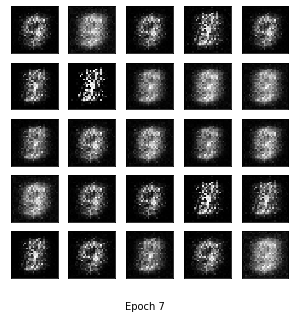

[8/8]: loss_d: 0.761, loss_g: 1.972


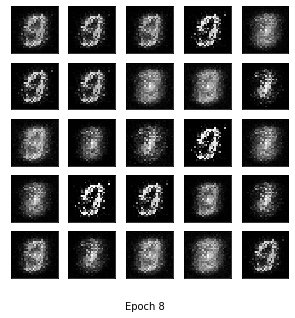

Training finish!... save training results


In [12]:
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

for epoch in range(train_epoch):

    Disc_losses = []
    Gen_losses = []

    for real, _ in train_loader:
        
        # train discriminator D

        D.zero_grad()
        real = real.view(-1, 28 * 28)
        mini_batch = real.size()[0]
        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        real, y_real_, y_fake_ = Variable(real.cpu()), Variable(y_real_.cpu()), Variable(y_fake_.cpu())
        
        Disc_result = D(real)

        y_real_ = (y_real_.unsqueeze(1)).float()
        Disc_real_loss = BCE_loss(Disc_result, y_real_)
#-----------------------------
        noise = torch.randn((mini_batch, 100))
        noise = Variable(noise.cpu())

        fake = G(noise)
        Disc_result = D(fake)

        y_fake_  = y_fake_.unsqueeze(1)
        y_fake_ = y_fake_.float()

        Disc_fake_loss = BCE_loss(Disc_result, y_fake_)
#-----------------------------
        Disc_train_loss = Disc_real_loss + Disc_fake_loss
#-----------------------------
        Disc_train_loss.backward()
        Disc_optimizer.step()

        Disc_losses.append(Disc_train_loss.item())

        # train generator 
        G.zero_grad()

        noise, y_real_ = Variable(noise.cpu()), Variable(y_real_.cpu())
        Gen_result = G(noise)
        Disc_result = D(Gen_result)

        Gen_train_loss = BCE_loss(Disc_result, y_real_)

        Gen_train_loss.backward()
        Gen_optimizer.step()

        Gen_losses.append(Gen_train_loss.item())

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
        (epoch + 1), train_epoch, torch.mean(torch.FloatTensor(Disc_losses)), torch.mean(torch.FloatTensor(Gen_losses))))
    
    p = 'MNIST_GANBN_results/Samples/MNIST_GANBN_' + str(epoch + 1) + '.png'
    
    show_result((epoch+1), show = True, save=True, path=p)
    
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(Disc_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(Gen_losses)))


print("Training finish!... save training results")

torch.save(G.state_dict(), "MNIST_GANBN_results/generator_param.pkl")
torch.save(D.state_dict(), "MNIST_GANBN_results/discriminator_param.pkl")


In [13]:
with open('MNIST_GANBN_results/train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

images = []
for e in range(train_epoch):
    img_name = 'MNIST_GANBN_results/Samples/MNIST_GANBN_' + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('MNIST_GANBN_results/generation_animation.gif', images, fps=5)

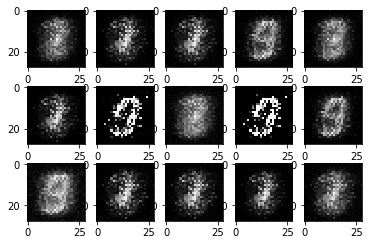

In [15]:
# load weights

D = discriminator(input_size=28*28, n_class=1).eval()
G = generator(input_size=100, n_class=28*28).eval()

D.load_state_dict(torch.load('MNIST_GANBN_results/discriminator_param.pkl'))
G.load_state_dict(torch.load('MNIST_GANBN_results/generator_param.pkl'))

batch_size = 15

noise = torch.randn((mini_batch, 100))

fake_images = G(noise)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)

Row, Col = 3, 5

for i in range(batch_size):
    plt.subplot(Row, Col, i + 1)
    plt.imshow(fake_images_np[i], cmap='gray')
    
plt.show()